In [1]:
import os
import glob
import json
import itertools
import numpy as np
from math import log
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from scipy.stats import pearsonr, spearmanr

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

In [2]:
# Careful! First install additional libraries using:
# # conda install -c conda-forge openpyxl -y
# # conda install -c conda-forge autograd -y
# # conda install -c conda-forge autograd-gamma -y
# # conda install -c conda-forge formulaic -y
# # pip install --no-deps --ignore-installed lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

# Clinical cox regression

In [3]:
# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)

In [4]:
invasive_path = os.path.join(
    config['retrained_benchmark_folder2'], "invasive_cancer_clustering", "kmeans")

metadata = pd.read_excel("../../data/TNBC/ST_TNBC_metadata.xlsx")
metadata['patient_id'] = metadata['ST_TNBC_ID'].apply(lambda x: f"TNBC{x}")  # Adjust column name if needed

In [5]:
patients_low_counts = []

# Load all TNBC models and HER2 full Koleo 16384 prototypes
for names, benchmark_path in zip(
  [config['retrained_model_list1'], config['retrained_model_list2']],
  [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):
    
  path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans")
  opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "optimal_clusters.csv"), index_col=0)
  
  for name in names:
    print(f"Processing model: {name}")
    n_clusters = opti_clusters.loc[name, 'n_clusters']
    filename = glob.glob(os.path.join(
      path_to_invasive_cancer_clustering_results, name, f"invasive_labels_{n_clusters}_clusters_umap_min_dist*"))[0]

    df = pd.read_csv(filename, index_col=0)
    df['patient_id'] = df.index.str.split('_').str[0]
    df_counts = df['patient_id'].value_counts()
    
    patients_low_counts.append(df['patient_id'].value_counts()[df['patient_id'].value_counts() < 100].index.tolist())

Processing model: uni
Processing model: uni_explora_kde_4096_prototypes
Processing model: uni_explora_kde_16384_prototypes
Processing model: uni_explora_kde_65536_prototypes
Processing model: uni_explora_koleo_4096_prototypes
Processing model: uni_explora_koleo_16384_prototypes
Processing model: uni_explora_koleo_65536_prototypes
Processing model: uni
Processing model: uni_full_kde_4096_prototypes
Processing model: uni_full_kde_16384_prototypes
Processing model: uni_full_kde_65536_prototypes
Processing model: uni_full_koleo_4096_prototypes
Processing model: uni_full_koleo_16384_prototypes
Processing model: uni_full_koleo_65536_prototypes


In [6]:
# Flatten list of lists
patients_low_counts_flat = [p for sub in patients_low_counts for p in sub]

# Optional: unique patient IDs while preserving order
patients_low_counts_unique = list(dict.fromkeys(patients_low_counts_flat))

# Quick check
print(len(patients_low_counts_unique), "patients with low spot counts (<100 patches) will be excluded.")

24 patients with low spot counts (<100 patches) will be excluded.


In [7]:
cph_dict = {}
cox_dfs = {}
dfs = {}

for names, benchmark_path in zip(
  [config['retrained_model_list1'], config['retrained_model_list2']],
  [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):

  path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans")
  opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "optimal_clusters.csv"), index_col=0)
  
  for name in names:
    n_clusters = opti_clusters.loc[name, 'n_clusters']
    filename = glob.glob(os.path.join(
      path_to_invasive_cancer_clustering_results, name, f"invasive_labels_{n_clusters}_clusters_umap_min_dist*"))[0]

    df = pd.read_csv(filename, index_col=0)
    df['patient_id'] = df.index.str.split('_').str[0]
    df = df[~df['patient_id'].isin(patients_low_counts_unique)]

    # Extract patient IDs from the spot names in df
    # Assuming spot names have format like "TNBC78_1x2" where "TNBC78" is the patient ID
    df['patient_id'] = df.index.str.split('_').str[0]

    # Count spots per cluster per patient
    cluster_counts = df.groupby(['patient_id', 'predicted_label']).size().reset_index(name='count')

    # Calculate total spots per patient
    total_spots = df.groupby('patient_id').size().reset_index(name='total')

    # Merge and calculate percentages
    cluster_composition = cluster_counts.merge(total_spots, on='patient_id')
    cluster_composition['percentage'] = (cluster_composition['count'] / cluster_composition['total']) * 100

    # Pivot to get one row per patient with columns for each cluster
    cluster_composition_wide = cluster_composition.pivot(
        index='patient_id', columns='predicted_label', values='percentage').fillna(0)

    # Rename columns to be more descriptive
    cluster_composition_wide.columns = [f'cluster_{col}_pct' for col in cluster_composition_wide.columns]
    
    # Merge the dataframes
    patient_data = cluster_composition_wide.merge(
        metadata[['patient_id', 'OS_years', 'OS-event', 'Age_at_diagnosis']], 
        left_index=True, right_on='patient_id', how='inner')
    patient_data.set_index('patient_id', inplace=True)
    cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]
    df = patient_data.dropna()

    # Handle zeros and normalize
    df[cluster_cols] = df[cluster_cols].clip(lower=1e-6)
    df[cluster_cols] = df[cluster_cols].div(df[cluster_cols].sum(axis=1), axis=0)

    # CLR transform
    log_vals = np.log(df[cluster_cols])
    clr_vals = log_vals.sub(log_vals.mean(axis=1), axis=0)
    clr_df = clr_vals.add_suffix("_clr")

    # Combine with survival data
    cox_df = pd.concat([df[["OS_years","OS-event"]], clr_df], axis=1)
    cox_dfs[name] = cox_df

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(cox_df, duration_col="OS_years", event_col="OS-event")
    cph_dict[name] = cph

    dfs[name] = df

CIs = {name: cph_dict[name].concordance_index_ for name in cph_dict}
df_CIs = (pd.Series(CIs, name='Concordance_Index').rename_axis('Model').reset_index())


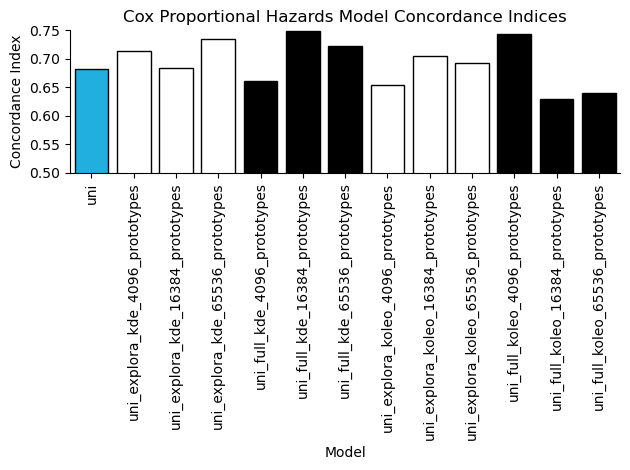

In [8]:
retrained_models = config['retrained_model_list1'] + config['retrained_model_list2'] 
sorted_retrained_models = sort_retrained_models(retrained_models)
df_CIs = (df_CIs.set_index("Model").loc[sorted_retrained_models].reset_index())

palette = []
for model in sorted_retrained_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")
        
sns.barplot(x='Model', y='Concordance_Index', data=df_CIs, palette=palette, edgecolor='black')
plt.xticks(rotation=90)
plt.ylim(0.5, 0.75)
plt.ylabel("Concordance Index")
plt.title("Cox Proportional Hazards Model Concordance Indices")
plt.tight_layout()
sns.despine()

plt.savefig(os.path.join(config['figures_folder'], "Figure4/clinical_cox_proportional_hazards_model_concordance_indices_all_models.pdf"), bbox_inches="tight")

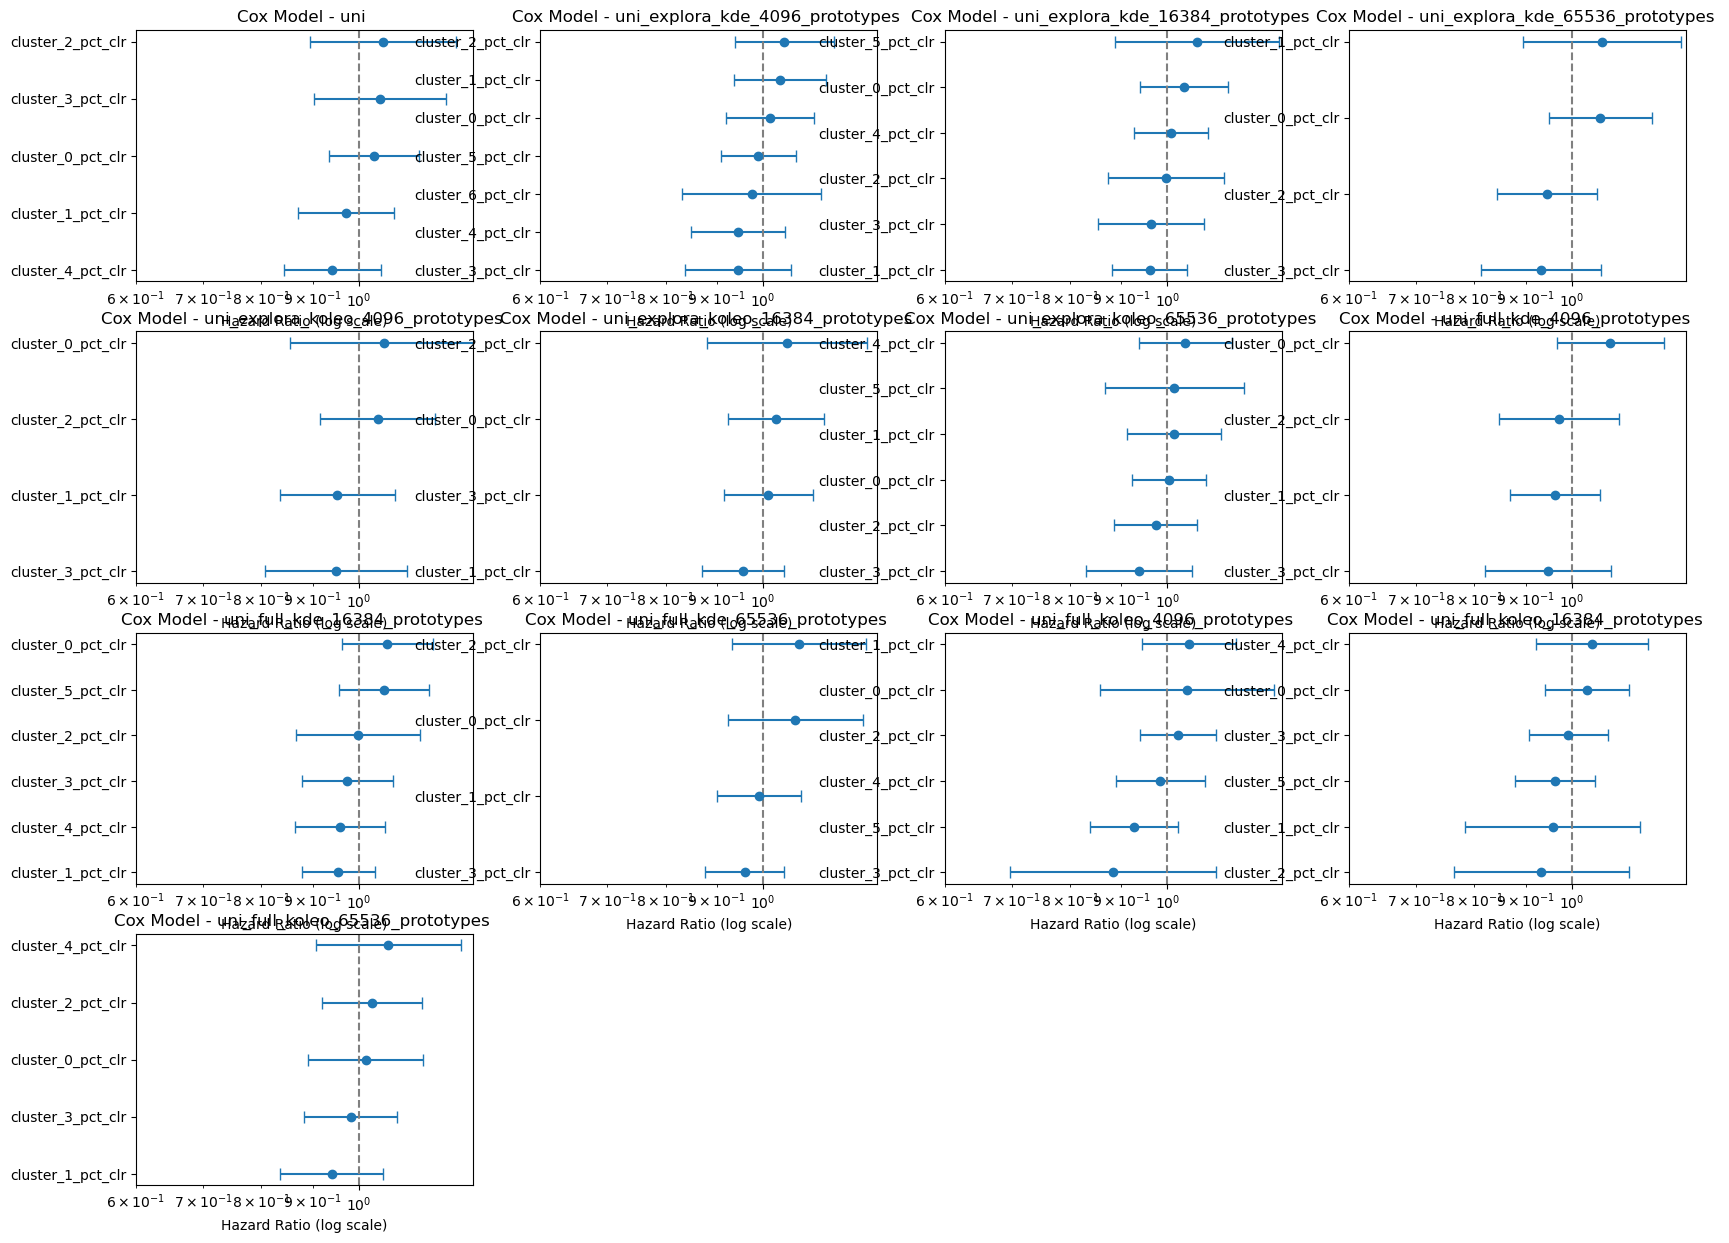

In [9]:
plt.figure(figsize=(20, 15))

i = 0
for name, cph in cph_dict.items():
    
    i += 1
    plt.subplot(4, int(np.ceil(len(cph_dict)/4)), i)
    summary = cph.summary.copy()
    summary = summary.sort_values("exp(coef)")  # Order visually
    hr = summary["exp(coef)"]
    ci_lower = summary["exp(coef) lower 95%"]
    ci_upper = summary["exp(coef) upper 95%"]
    labels = summary.index

    plt.errorbar(hr, labels, xerr=[hr-ci_lower, ci_upper-hr], fmt='o', capsize=4)
    plt.axvline(1, color='grey', linestyle='--')
    plt.xlabel("Hazard Ratio (log scale)")
    plt.xscale("log")
    plt.xlim(0.6, 1.3)
    plt.title(f"Cox Model - {name} ")
    plt.tight_layout 
    
plt.show()

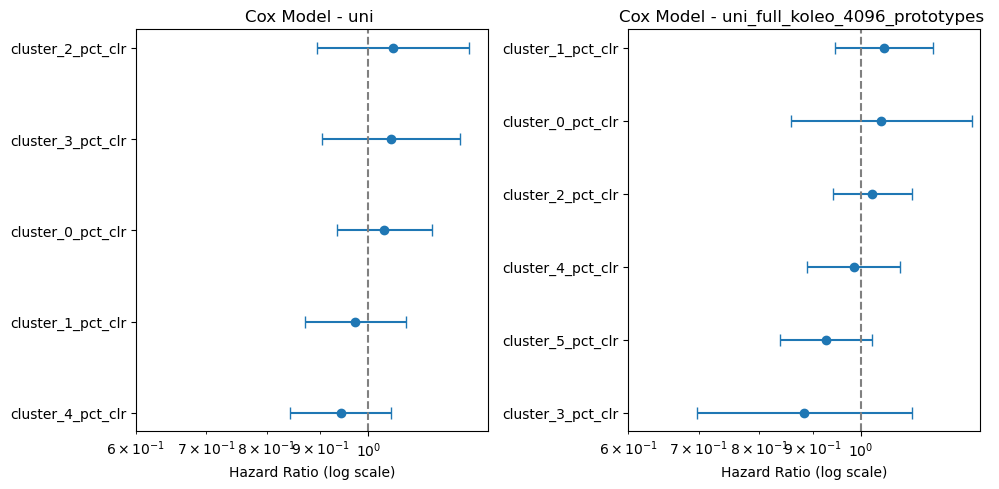

In [10]:
plt.figure(figsize=(10, 5))

i = 0
for name, cph in cph_dict.items():
    if name not in ["uni", "uni_full_koleo_4096_prototypes"]:
        continue
    i += 1
    plt.subplot(1, 2, i)
    summary = cph.summary.copy()
    summary = summary.sort_values("exp(coef)")  # Order visually
    hr = summary["exp(coef)"]
    ci_lower = summary["exp(coef) lower 95%"]
    ci_upper = summary["exp(coef) upper 95%"]
    labels = summary.index

    plt.errorbar(hr, labels, xerr=[hr-ci_lower, ci_upper-hr], fmt='o', capsize=4)
    plt.axvline(1, color='grey', linestyle='--')
    plt.xlabel("Hazard Ratio (log scale)")
    plt.xscale("log")
    plt.xlim(0.6, 1.3)
    plt.title(f"Cox Model - {name} ")
    plt.tight_layout()

plt.show()

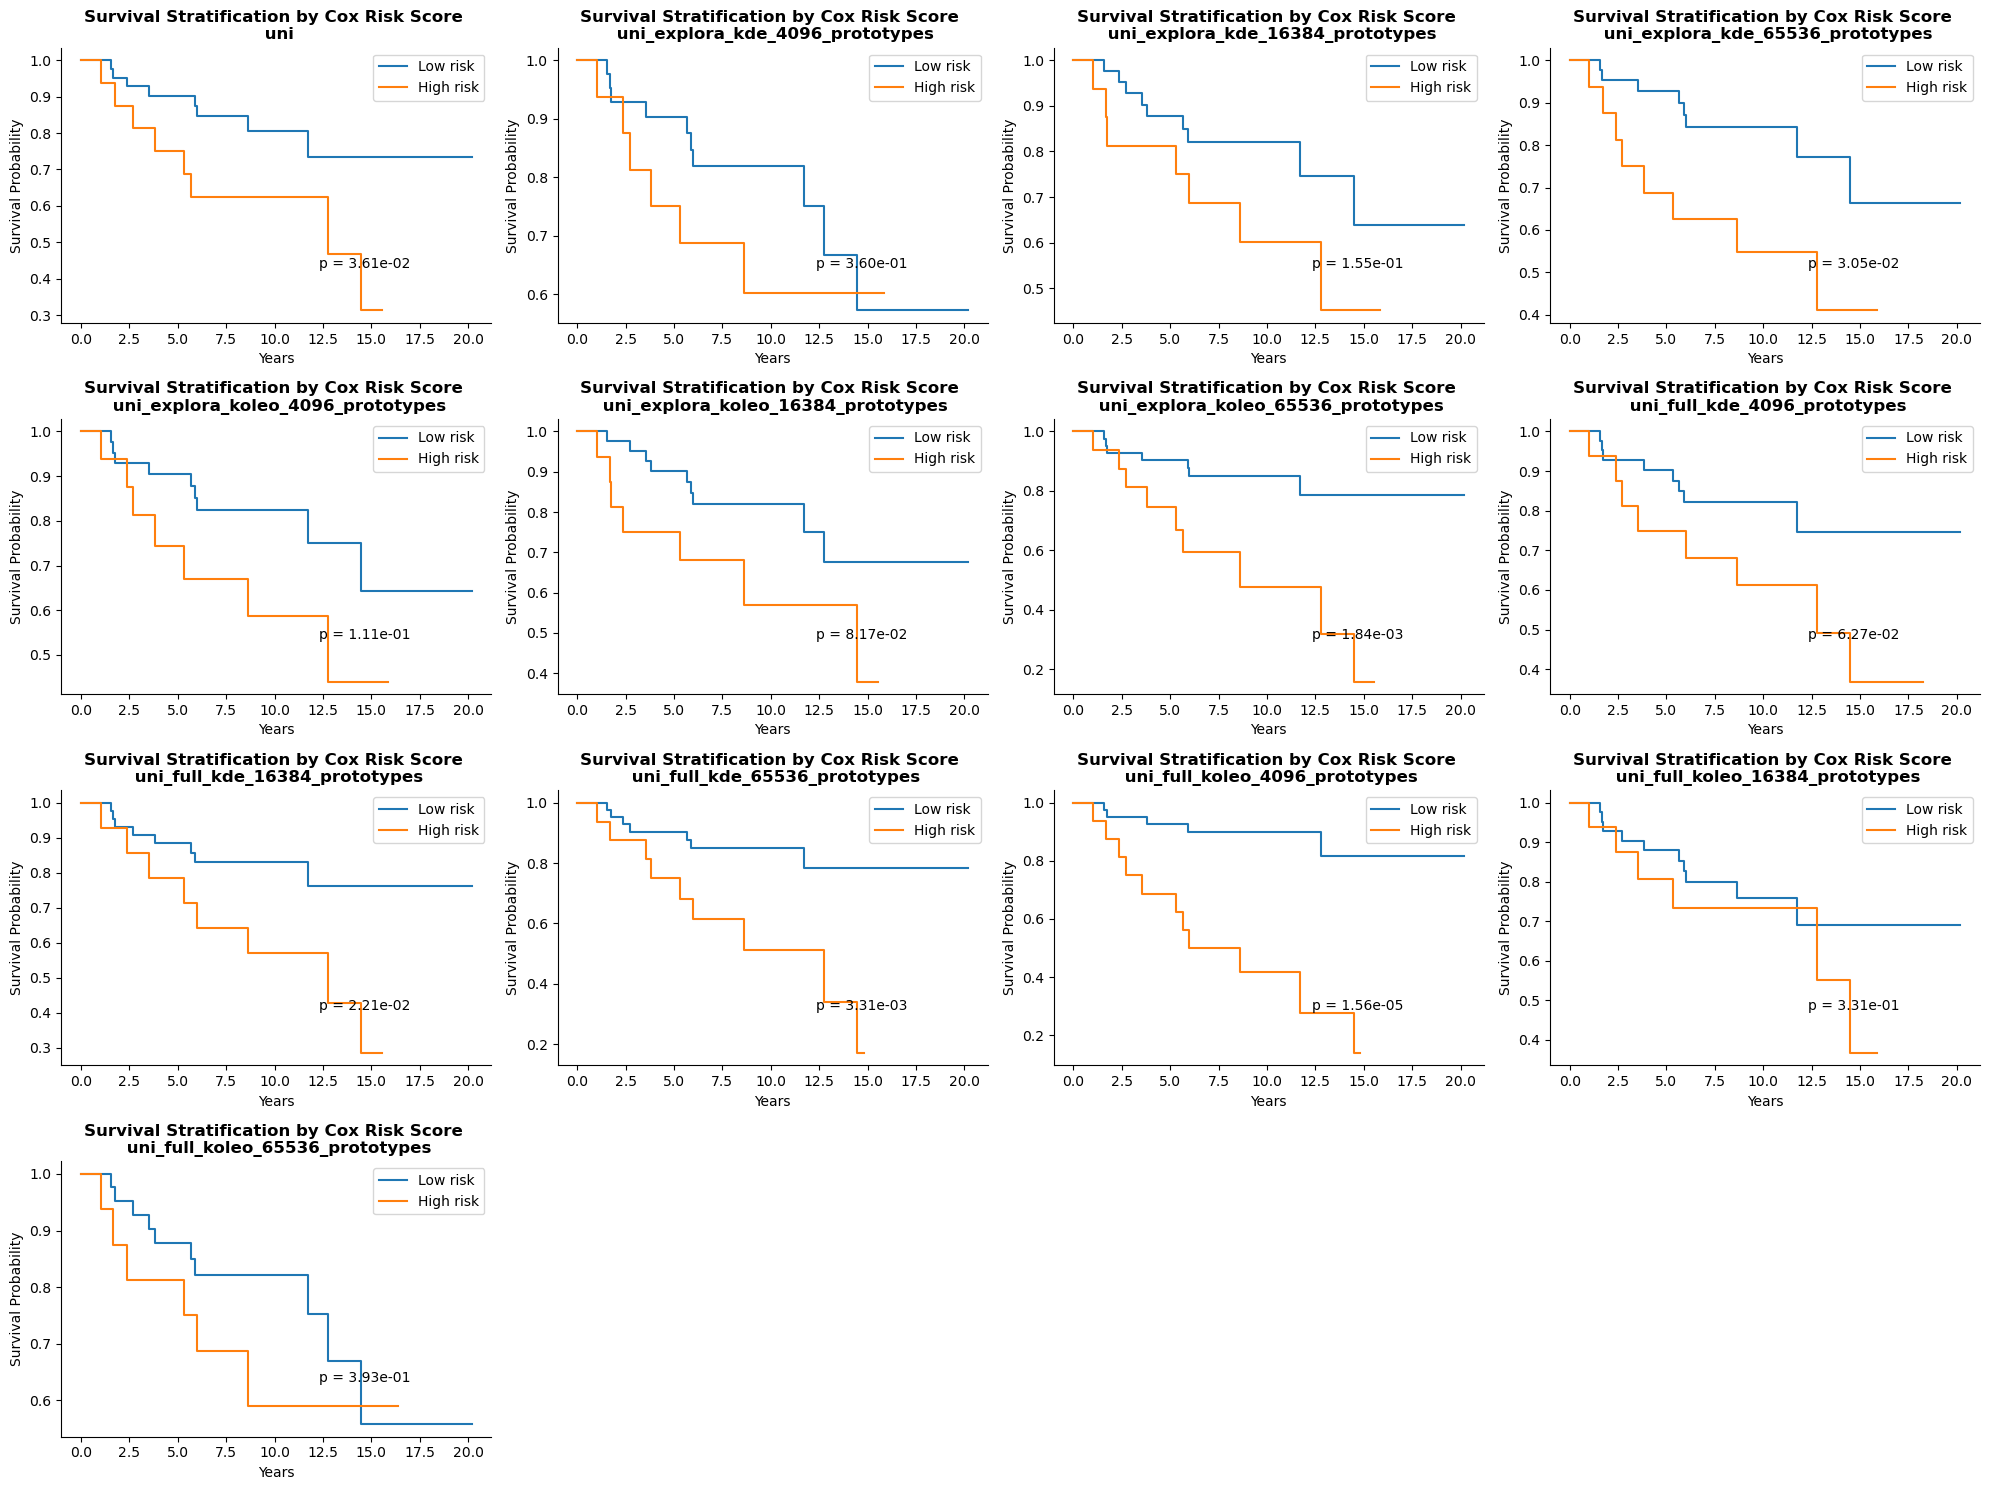

In [11]:
# Compute risk score (linear predictor)
plt.figure(figsize=(20, 15))

i = 0
dict_pvals = {}

for name, cph in cph_dict.items():
    
    i += 1
    plt.subplot(4, int(np.ceil(len(cph_dict)/4)), i)
    cox_dfs[name]["risk_score"] = cph.predict_partial_hazard(cox_dfs[name])

    # Stratify into High vs Low using median
    median = cox_dfs[name]["risk_score"].quantile(1 - cox_df["OS-event"].sum()/len(cox_df["OS-event"]))
    cox_dfs[name]["risk_group"] = np.where(cox_dfs[name]["risk_score"] > median, "High risk", "Low risk")

    # Fit KMF curves
    km = KaplanMeierFitter()

    for group in ["Low risk", "High risk"]:
        mask = cox_dfs[name]["risk_group"] == group
        km.fit(cox_dfs[name].loc[mask, "OS_years"],
            cox_dfs[name].loc[mask, "OS-event"],
            label=group)
        km.plot(ci_show=False)

    plt.title(f"Survival Stratification by Cox Risk Score \n uni_full_koleo_4096_prototypes", weight='bold')
    plt.xlabel("Years")
    plt.ylabel("Survival Probability")

    # Log-rank test
    res = logrank_test(
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="Low risk", "OS_years"],
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="High risk", "OS_years"],
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="Low risk", "OS-event"],
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="High risk", "OS-event"]
    )
    plt.text(0.6, 0.2, f"p = {res.p_value:.2e}", transform=plt.gca().transAxes)
    plt.title(f"Survival Stratification by Cox Risk Score \n {name}", weight='bold')
    plt.tight_layout()
    sns.despine()
    dict_pvals[name] = res.p_value
    
plt.show()

In [12]:
df_pvals = pd.DataFrame.from_dict(dict_pvals, orient='index', columns=['logrank_p_value'])
df_pvals["-log10(P-value)"] = -np.log10(df_pvals['logrank_p_value'])

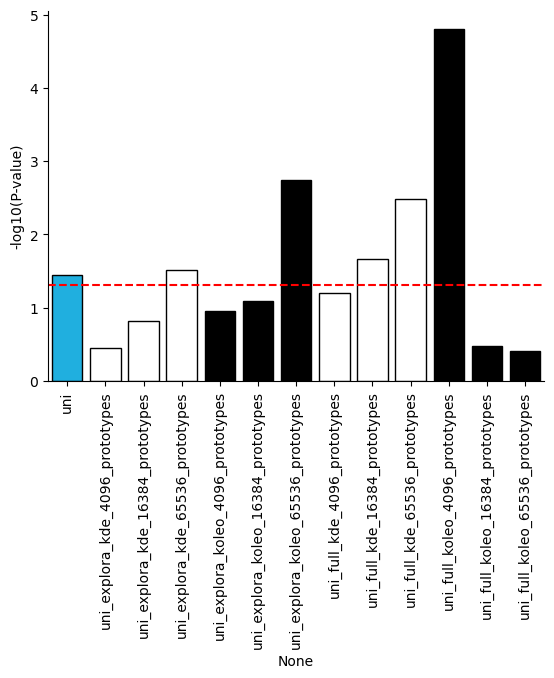

In [13]:
sns.barplot(x=df_pvals.index, y='-log10(P-value)', data=df_pvals, palette=palette, edgecolor='black')
plt.xticks(rotation=90)
sns.despine()
plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.savefig(os.path.join(config['figures_folder'], "Figure4/clinical_cox_all_models_pval_survival.pdf"), bbox_inches="tight")

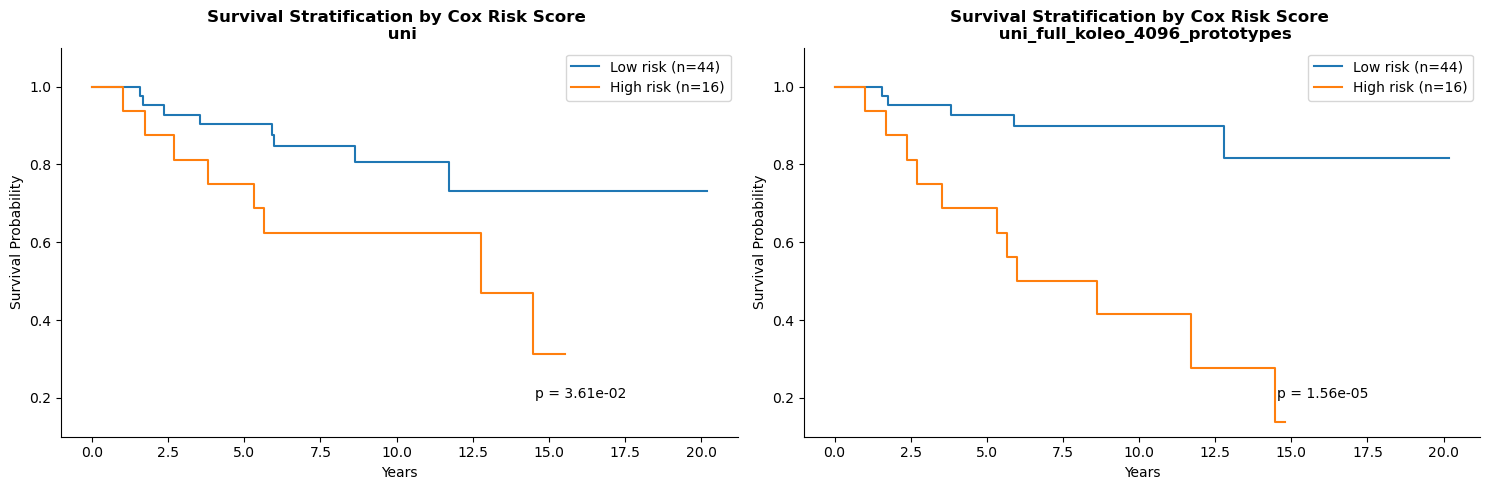

In [14]:
plt.figure(figsize=(15, 5))

i = 0
for name, cph in cph_dict.items():
    if name not in ["uni", "uni_full_koleo_4096_prototypes"]:
        continue
    
    i += 1
    plt.subplot(1, 2, i)
    cox_dfs[name]["risk_score"] = cph.predict_partial_hazard(cox_dfs[name])

    # Stratify into High vs Low using median
    # median = cox_dfs[name]["risk_score"].median()
    median = cox_dfs[name]["risk_score"].quantile(1 - cox_df["OS-event"].sum()/len(cox_df["OS-event"]))
    cox_dfs[name]["risk_group"] = np.where(cox_dfs[name]["risk_score"] > median, f"High risk", "Low risk")
    
    # Fit KMF curves
    km = KaplanMeierFitter()

    for group in ["Low risk", "High risk"]:
        mask = cox_dfs[name]["risk_group"] == group
        km.fit(cox_dfs[name].loc[mask, "OS_years"],
            cox_dfs[name].loc[mask, "OS-event"],
            label=f"{group} (n={len(mask[mask == True])})")
        km.plot(ci_show=False)

    plt.title(f"Survival Stratification by Cox Risk Score \n uni_full_koleo_4096_prototypes", weight='bold')
    plt.xlabel("Years")
    plt.ylabel("Survival Probability")

    # Log-rank test
    res = logrank_test(
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="Low risk", "OS_years"],
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="High risk", "OS_years"],
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="Low risk", "OS-event"],
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="High risk", "OS-event"]
    )
    plt.text(0.7, 0.1, f"p = {res.p_value:.2e}", transform=plt.gca().transAxes)
    plt.title(f"Survival Stratification by Cox Risk Score \n {name}", weight='bold')
    plt.tight_layout()
    plt.ylim(0.1, 1.1)
    sns.despine()

plt.show()

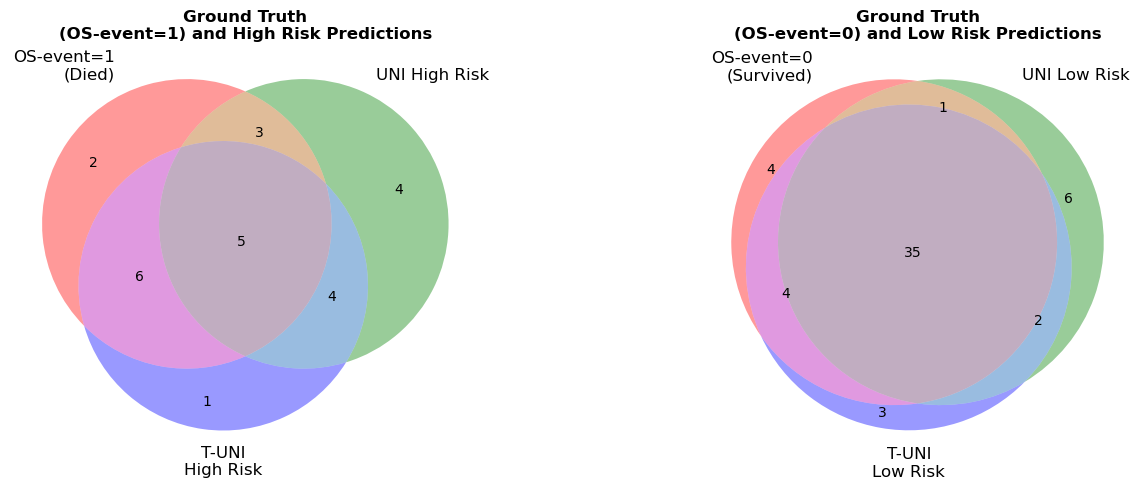

In [15]:
# Get patients in high and low risk groups for each model
uni_high_risk = set(cox_dfs["uni"][cox_dfs["uni"]["risk_group"] == "High risk"].index)
full_high_risk = set(cox_dfs["uni_full_koleo_4096_prototypes"][cox_dfs["uni_full_koleo_4096_prototypes"]["risk_group"] == "High risk"].index)
uni_low_risk = set(cox_dfs["uni"][cox_dfs["uni"]["risk_group"] == "Low risk"].index)
full_low_risk = set(cox_dfs["uni_full_koleo_4096_prototypes"][cox_dfs["uni_full_koleo_4096_prototypes"]["risk_group"] == "Low risk"].index)

# Get ground truth from OS-event (1=died/high risk, 0=survived/low risk)
ground_truth_high_risk = set(cox_dfs["uni"][cox_dfs["uni"]["OS-event"] == 1].index)
ground_truth_low_risk = set(cox_dfs["uni"][cox_dfs["uni"]["OS-event"] == 0].index)

# Create figure with 2 Venn diagrams
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# # High Risk Venn diagram
# plt.sca(axes[0])
# venn2([uni_high_risk, full_high_risk], set_labels=('UNI High Risk', 'UNI-Full High Risk'))
# axes[0].set_title("Overlap of High Risk Patients\nBetween UNI and UNI-Full Models", weight='bold')

# # Low Risk Venn diagram
# plt.sca(axes[1])
# venn2([uni_low_risk, full_low_risk], set_labels=('UNI Low Risk', 'UNI-Full Low Risk'))
# axes[1].set_title("Overlap of Low Risk Patients\nBetween UNI and UNI-Full Models", weight='bold')

# # Ground Truth (OS-event) with 3-way Venn diagram - High Risk
plt.sca(axes[0])
venn3([ground_truth_high_risk, uni_high_risk, full_high_risk], set_labels=('OS-event=1\n(Died)', 'UNI High Risk', 'T-UNI\nHigh Risk'))
axes[0].set_title("Ground Truth\n(OS-event=1) and High Risk Predictions", weight='bold')
plt.tight_layout()

plt.sca(axes[1])
venn3([ground_truth_low_risk, uni_low_risk, full_low_risk], set_labels=('OS-event=0\n(Survived)', 'UNI Low Risk', 'T-UNI\nLow Risk'))
axes[1].set_title("Ground Truth\n(OS-event=0) and Low Risk Predictions", weight='bold')

plt.tight_layout()
plt.show()

In [16]:
# Look at extremes slides
cox_df = cox_dfs["uni_full_koleo_4096_prototypes"]
cox_df.head()

,OS_years,OS-event,cluster_0_pct_clr,cluster_1_pct_clr,cluster_2_pct_clr,cluster_3_pct_clr,cluster_4_pct_clr,cluster_5_pct_clr,risk_score,risk_group
patient_id,,,,,,,,,,
TNBC11,2.375342,1.0,7.705146,-7.859625,10.495862,5.377868,-7.859625,-7.859625,1.583293,High risk
TNBC14,6.816438,0.0,1.162529,1.803230,-2.658839,1.727345,0.624575,-2.658839,1.279240,Low risk
TNBC15,8.879452,0.0,2.075200,4.195464,-12.976271,4.968654,-0.815171,2.552124,0.531273,Low risk
TNBC16,12.775342,1.0,5.998022,-11.204087,5.244251,6.497014,4.668887,-11.204087,0.999702,Low risk
TNBC20,6.131507,0.0,2.157977,0.369309,1.658440,1.107713,-3.619675,-1.673765,1.487514,High risk


In [17]:
df = dfs["uni_full_koleo_4096_prototypes"]
df.head()

,cluster_0_pct,cluster_1_pct,cluster_2_pct,cluster_3_pct,cluster_4_pct,cluster_5_pct,OS_years,OS-event,Age_at_diagnosis
patient_id,,,,,,,,,
TNBC11,0.057504,1.000000e-08,9.368864e-01,0.005610,1.000000e-08,1.000000e-08,2.375342,1.0,67
TNBC14,0.189227,3.591160e-01,4.143646e-03,0.332873,1.104972e-01,4.143646e-03,6.816438,0.0,35
TNBC15,0.034417,2.868069e-01,1.000000e-08,0.621415,1.912046e-03,5.544933e-02,8.879452,0.0,44
TNBC16,0.295652,1.000000e-08,1.391304e-01,0.486957,7.826087e-02,1.000000e-08,12.775342,1.0,70
TNBC20,0.465418,7.780980e-02,2.824207e-01,0.162824,1.440922e-03,1.008646e-02,6.131507,0.0,54


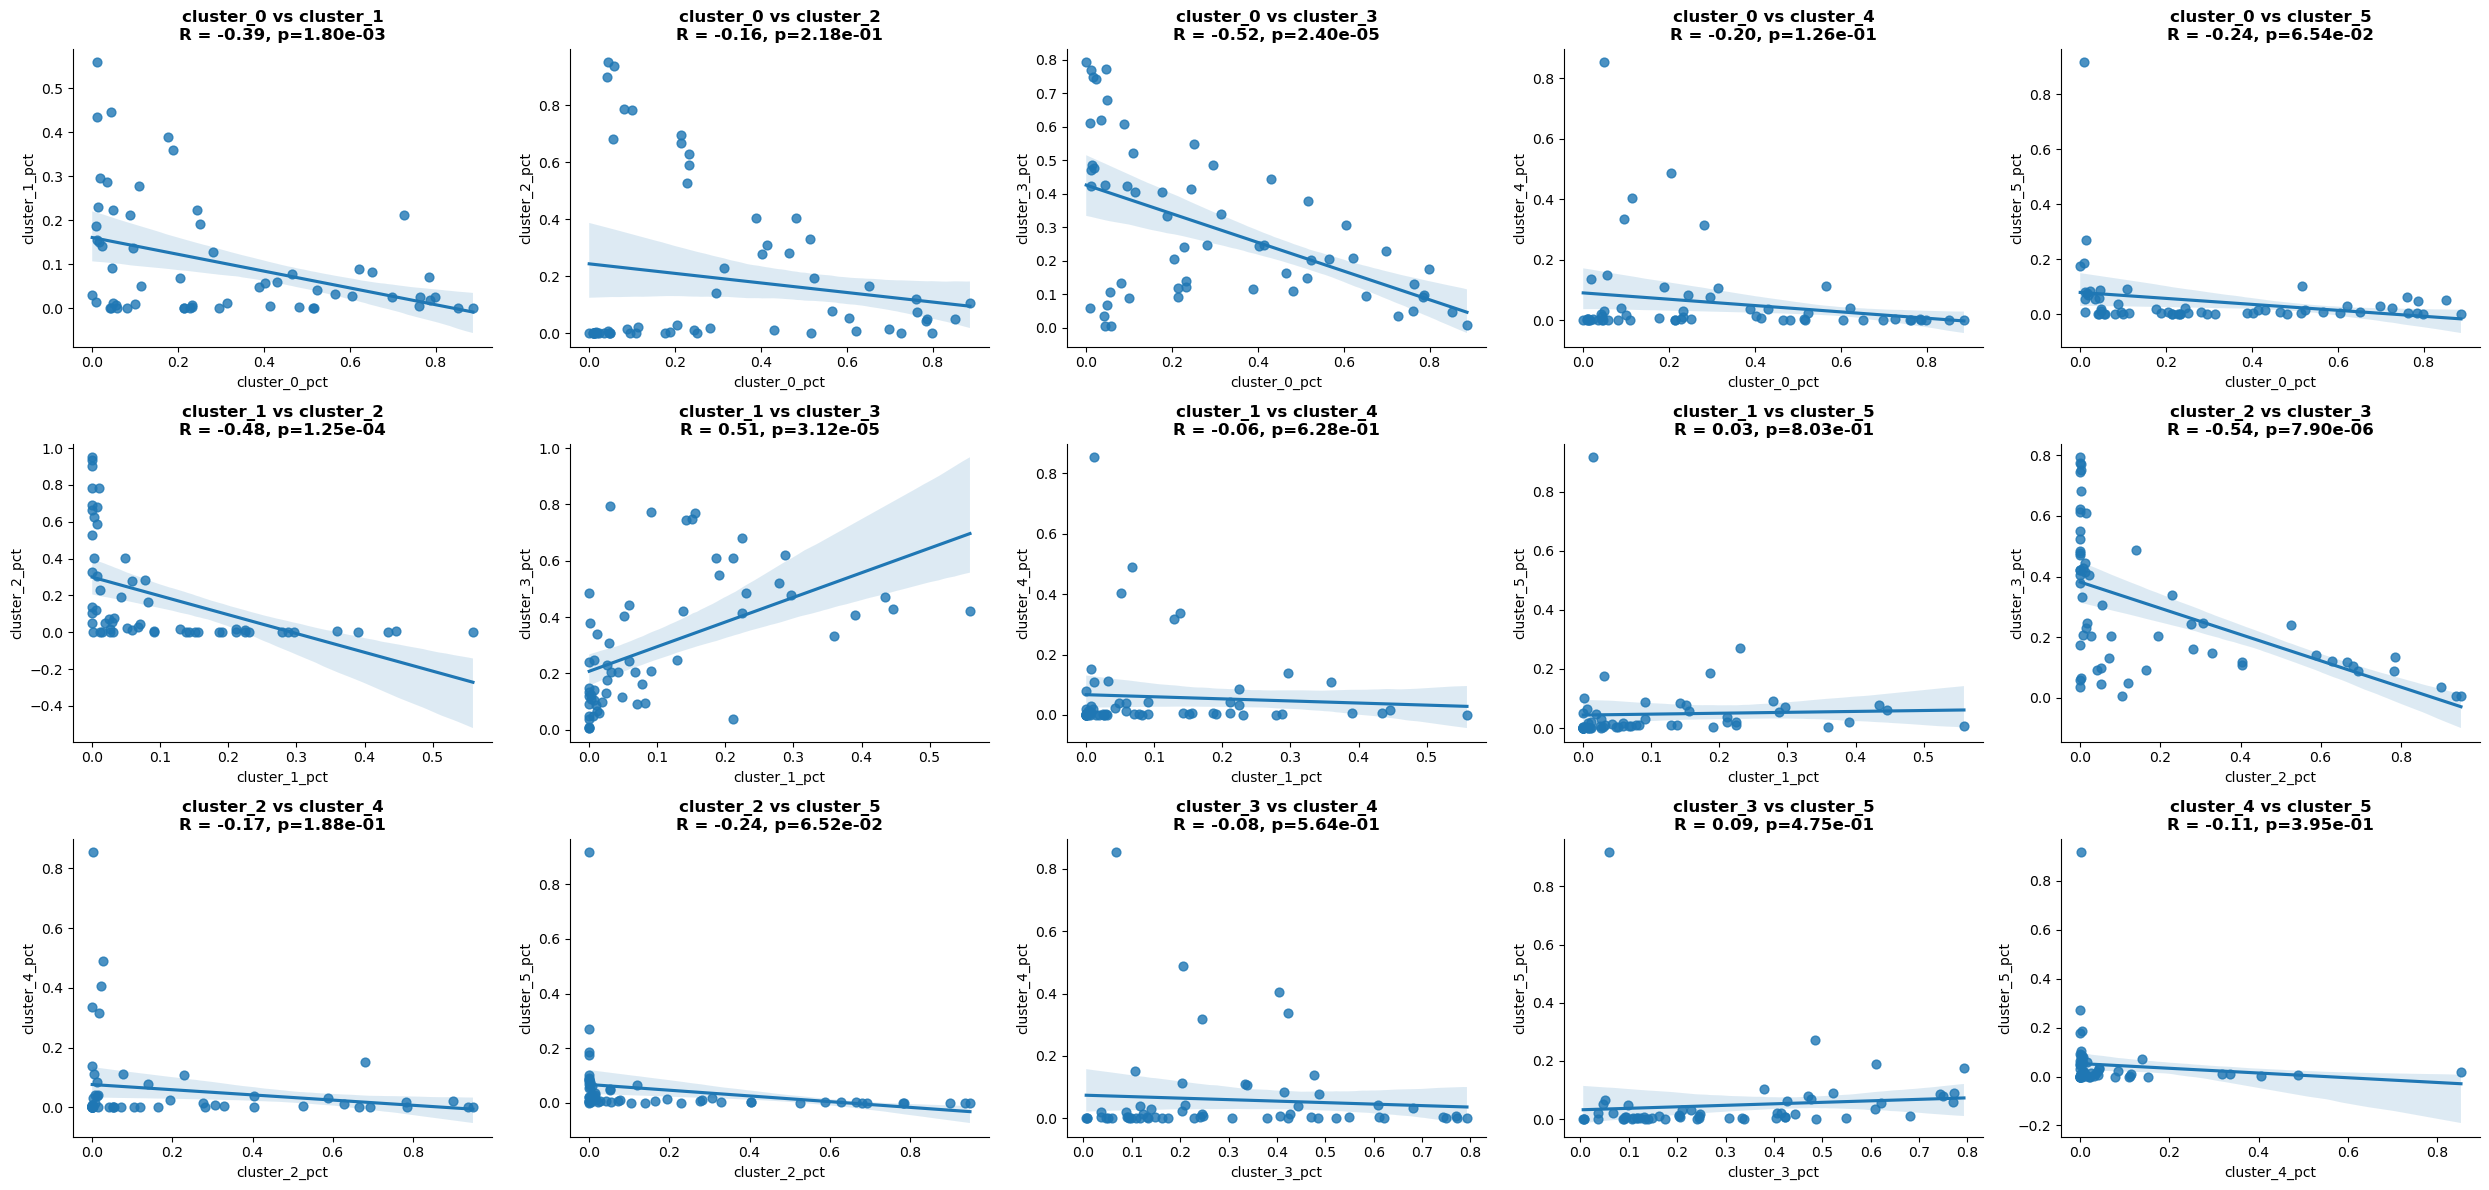

In [18]:
cluster_cols = [c for c in df.columns if c.startswith("cluster_") and c.endswith("_pct")]
pairs = list(itertools.combinations(cluster_cols, 2))

n = len(pairs)
cols = 5
rows = int(np.ceil(n / cols))

plt.figure(figsize=(cols * 5, rows * 4))
for i, (x, y) in enumerate(pairs, start=1):
    ax = plt.subplot(rows, cols, i)
    sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws={"s": 40})
    r, p = pearsonr(df[x], df[y])
    ax.set_title(f"{x.split('_pct')[0]} vs {y.split('_pct')[0]}\nR = {r:.2f}, p={p:.2e}", weight="bold")
    sns.despine()
    
plt.tight_layout()

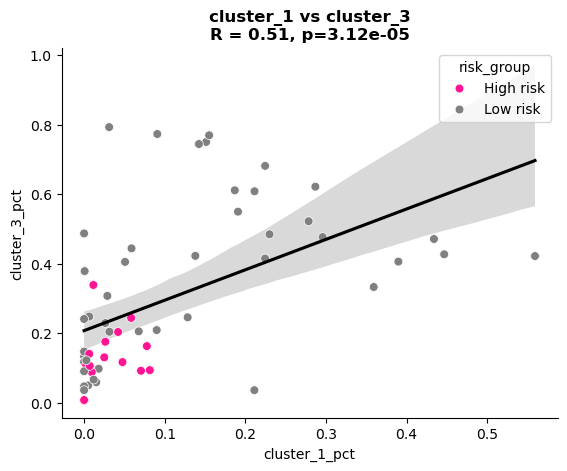

In [19]:
df_no_null = df[(df["cluster_1_pct"] > 0) & (df["cluster_3_pct"] > 0)]
df_no_null = df_no_null.merge(cox_df[["risk_group"]], left_index=True, right_index=True)
x = "cluster_1_pct"
y = "cluster_3_pct"
sns.regplot(data=df_no_null, x=x, y=y, scatter_kws={"s": 2}, color='black')
sns.scatterplot(data=df_no_null, x=x, y=y, s=40, hue='risk_group', palette={'deeppink', 'gray', })
r, p = pearsonr(df_no_null[x], df_no_null[y])
plt.title(f"{x.split('_pct')[0]} vs {y.split('_pct')[0]}\nR = {r:.2f}, p={p:.2e}", weight="bold")
sns.despine()